# Exploratory Data Analysis

In [1]:
import polars as pl

# define the schema of the dataframe
event_schema = pl.Struct({"aid": pl.Int32, "ts": pl.Int64, "type": str})
df_schema = {"session": pl.Int32, "events": pl.List(event_schema)}

df = pl.read_ndjson('../data/train.jsonl', schema=df_schema, low_memory=True)

print(df.head())

exploded_df = (
    df
    .explode("events")
    .unnest("events")
)

print(exploded_df)

shape: (5, 2)
┌─────────┬─────────────────────────────────┐
│ session ┆ events                          │
│ ---     ┆ ---                             │
│ i32     ┆ list[struct[3]]                 │
╞═════════╪═════════════════════════════════╡
│ 0       ┆ [{1517085,1659304800025,"click… │
│ 1       ┆ [{424964,1659304800025,"carts"… │
│ 2       ┆ [{763743,1659304800038,"clicks… │
│ 3       ┆ [{1425967,1659304800095,"carts… │
│ 4       ┆ [{613619,1659304800119,"clicks… │
└─────────┴─────────────────────────────────┘
shape: (216_716_096, 4)
┌──────────┬─────────┬───────────────┬────────┐
│ session  ┆ aid     ┆ ts            ┆ type   │
│ ---      ┆ ---     ┆ ---           ┆ ---    │
│ i32      ┆ i32     ┆ i64           ┆ str    │
╞══════════╪═════════╪═══════════════╪════════╡
│ 0        ┆ 1517085 ┆ 1659304800025 ┆ clicks │
│ 0        ┆ 1563459 ┆ 1659304904511 ┆ clicks │
│ 0        ┆ 1309446 ┆ 1659367439426 ┆ clicks │
│ 0        ┆ 16246   ┆ 1659367719997 ┆ clicks │
│ 0        ┆ 1781822 ┆ 1

### Amount of events per session

In [2]:
# amount of events per session
session_events_count = (
    df
    .select(pl.col("events"))
    .with_columns(session_events_count = pl.col("events").list.len())
    .sort("session_events_count")
    .select("session_events_count")
)

print(session_events_count)
print(session_events_count.describe())

shape: (12_899_779, 1)
┌──────────────────────┐
│ session_events_count │
│ ---                  │
│ u32                  │
╞══════════════════════╡
│ 2                    │
│ 2                    │
│ 2                    │
│ 2                    │
│ 2                    │
│ …                    │
│ 498                  │
│ 499                  │
│ 499                  │
│ 500                  │
│ 500                  │
└──────────────────────┘
shape: (9, 2)
┌────────────┬──────────────────────┐
│ statistic  ┆ session_events_count │
│ ---        ┆ ---                  │
│ str        ┆ f64                  │
╞════════════╪══════════════════════╡
│ count      ┆ 1.2899779e7          │
│ null_count ┆ 0.0                  │
│ mean       ┆ 16.799985            │
│ std        ┆ 33.57738             │
│ min        ┆ 2.0                  │
│ 25%        ┆ 3.0                  │
│ 50%        ┆ 6.0                  │
│ 75%        ┆ 15.0                 │
│ max        ┆ 500.0                │
└─────

In [3]:
# Count how many percent are under 100 events
under_100 = session_events_count.filter(pl.col("session_events_count") < 100).height
total = session_events_count.height
print(f"Percentage of sessions with less than 100 events: {under_100 / total * 100:.2f}%")

# Count how many percent are under 10 events
under_10 = session_events_count.filter(pl.col("session_events_count") < 10).height
total = session_events_count.height
print(f"Percentage of sessions with less than 10 events: {under_10 / total * 100:.2f}%")

# Count how many percent are under 5 events
under_5 = session_events_count.filter(pl.col("session_events_count") < 5).height
total = session_events_count.height
print(f"Percentage of sessions with less than 5 events: {under_5 / total * 100:.2f}%")

# Count how many percent are 2 events
exactly_2 = session_events_count.filter(pl.col("session_events_count") == 2).height
total = session_events_count.height
print(f"Percentage of sessions with 2 events: {exactly_2 / total * 100:.2f}%")

Percentage of sessions with less than 100 events: 97.17%
Percentage of sessions with less than 10 events: 63.91%
Percentage of sessions with less than 5 events: 40.90%
Percentage of sessions with 2 events: 19.34%


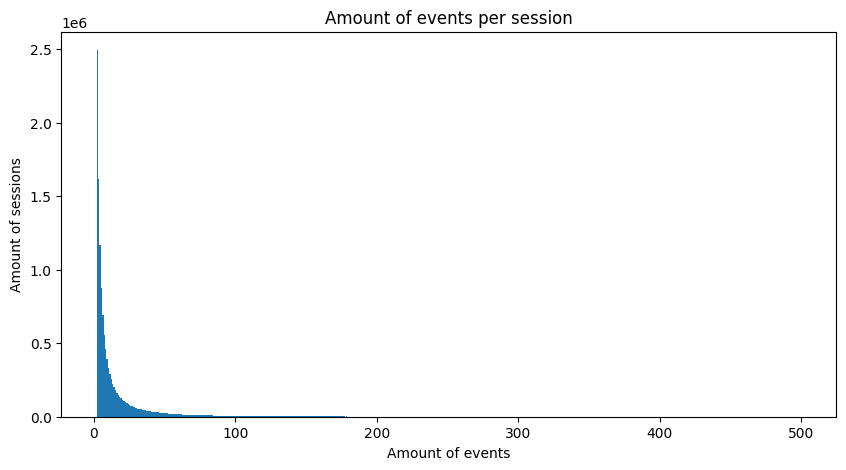

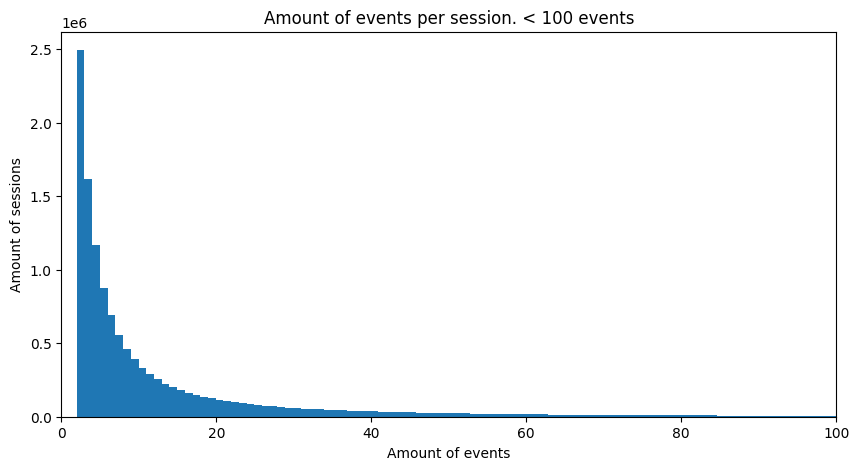

In [4]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 5))
plt.hist(session_events_count.to_numpy(), bins=500)
plt.title("Amount of events per session")
plt.xlabel("Amount of events")
plt.ylabel("Amount of sessions")
plt.show()

plt.figure(figsize=(10, 5))
plt.hist(session_events_count.to_numpy(), bins=500)
plt.xlim(0, 100)
plt.title("Amount of events per session. < 100 events")
plt.xlabel("Amount of events")
plt.ylabel("Amount of sessions")
plt.show()

### Amount of each event type

In [ ]:
# count amount of each event type
events_count = (
    df
    .select(pl.col("events"))
    .explode("events")
    .unnest("events")
    .select(["type"])
    .rename({"type": "event_type"})
    .group_by("event_type")
    .agg(
        pl.count("event_type")
        .alias("count")
    )
)

print(events_count)

In [6]:
def add_labels(x,y):
    for i in range(len(x)):
        if isinstance(y[i], float):
            plt.text(i, y[i], f"{y[i]:.2f}", ha = 'center')
        else:
            plt.text(i, y[i], y[i], ha = 'center')

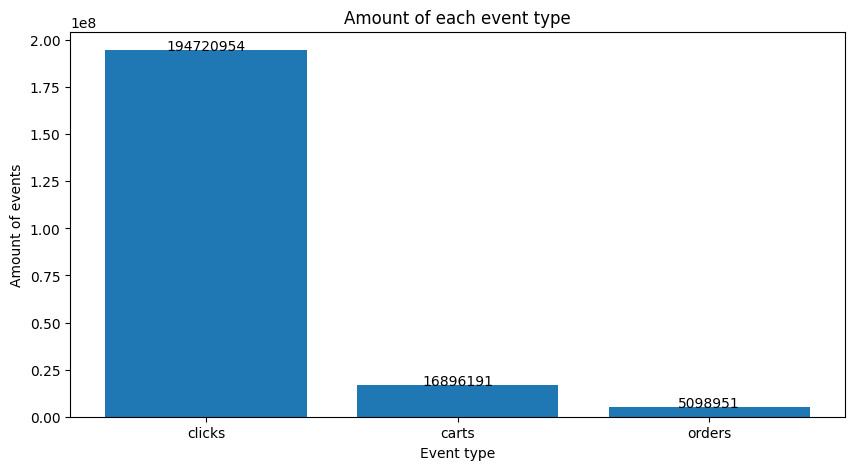

In [7]:
plt.figure(figsize=(10, 5))
plt.bar(events_count["event_type"].to_numpy(), events_count["count"].to_numpy())
add_labels(events_count["event_type"].to_numpy(), events_count["count"].to_numpy())
plt.title("Amount of each event type")
plt.xlabel("Event type")
plt.ylabel("Amount of events")
plt.show()

### Amount of events per aid

In [8]:
# count amount of events per aid
events_per_aid = (
    df
    .select(pl.col("events"))
    .explode("events")
    .unnest("events")
    .select(["aid"])
    .group_by("aid")
    .agg(
        pl.count("aid")
        .alias("events_count")
    )
    .sort("events_count")
)

print(events_per_aid)
print(events_per_aid.select("events_count").describe())

event_counts_distribution = (
    events_per_aid
    .select("events_count")
    .group_by("events_count")
    .agg(
        pl.count("events_count")
        .alias("aids_count")
    )
    .sort("events_count")
)

shape: (1_855_603, 2)
┌─────────┬──────────────┐
│ aid     ┆ events_count │
│ ---     ┆ ---          │
│ i32     ┆ u32          │
╞═════════╪══════════════╡
│ 679262  ┆ 3            │
│ 1166769 ┆ 3            │
│ 1726329 ┆ 3            │
│ 1164783 ┆ 3            │
│ 494968  ┆ 3            │
│ …       ┆ …            │
│ 1733943 ┆ 105091       │
│ 29735   ┆ 113279       │
│ 108125  ┆ 118524       │
│ 485256  ┆ 126836       │
│ 1460571 ┆ 129004       │
└─────────┴──────────────┘
shape: (9, 2)
┌────────────┬──────────────┐
│ statistic  ┆ events_count │
│ ---        ┆ ---          │
│ str        ┆ f64          │
╞════════════╪══════════════╡
│ count      ┆ 1.855603e6   │
│ null_count ┆ 0.0          │
│ mean       ┆ 116.790119   │
│ std        ┆ 728.854992   │
│ min        ┆ 3.0          │
│ 25%        ┆ 9.0          │
│ 50%        ┆ 20.0         │
│ 75%        ┆ 56.0         │
│ max        ┆ 129004.0     │
└────────────┴──────────────┘


[5.6513165801089995, 23.11065459583758, 22.358284611525203, 22.023730291447038, 10.688978191994732, 4.4035281253587115, 2.4837748160570983, 1.624323737351147, 3.6806903200738517, 2.1064311708916184, 1.8682875593540211]
100.0


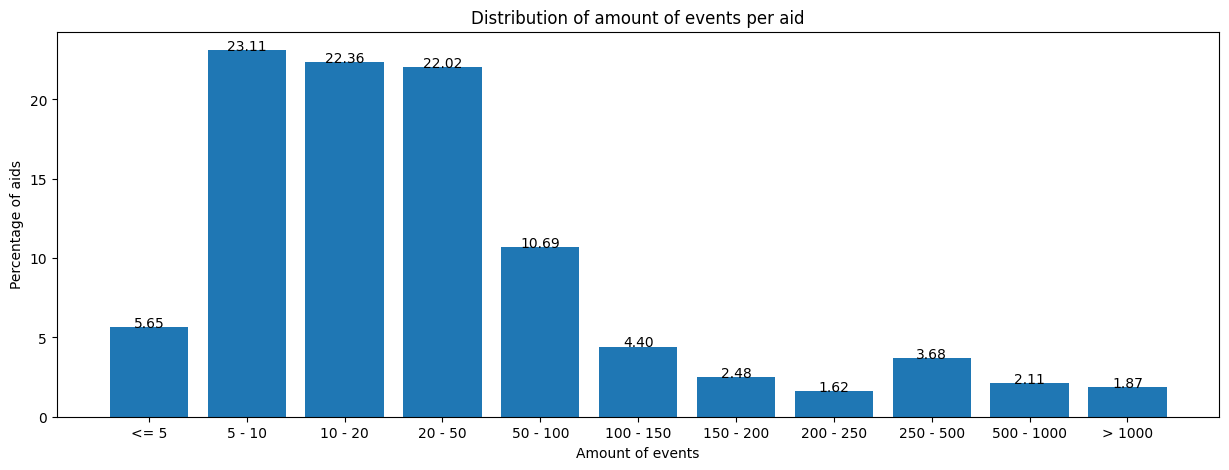

In [9]:
def get_percentage_under_n_events(amount_of_events):
    percentages = []
    labels = []

    total = events_per_aid.height
    len_events = len(amount_of_events)
    for i in range(len_events):
        if i == 0:
            count = events_per_aid.filter(pl.col("events_count") <= amount_of_events[i]).height
            percentages.append(count / total * 100)
            labels.append(f"<= {amount_of_events[i]}")
            continue

        n1 = amount_of_events[i-1]
        n2 = amount_of_events[i]

        count = events_per_aid.filter(pl.col("events_count") > n1, pl.col("events_count") <= n2).height
        percentages.append(count / total * 100)
        labels.append(f"{n1} - {n2}")

        if i == len_events-1:
            count = events_per_aid.filter(pl.col("events_count") > amount_of_events[i]).height
            percentages.append(count / total * 100)
            labels.append(f"> {amount_of_events[i]}")
            continue

    return percentages, labels

amount_of_events = [5, 10, 20, 50, 100, 150, 200, 250, 500, 1000]
percentages, labels = get_percentage_under_n_events(amount_of_events)
print(percentages)
print(sum(percentages))

plt.figure(figsize=(15, 5))
plt.bar(labels, percentages)
add_labels(labels, percentages)
plt.title("Distribution of amount of events per aid")
plt.xlabel("Amount of events")
plt.ylabel("Percentage of aids")
plt.show()

The distribution of the amount of events per aid is very skewed. many aids have very few events, while a few have a lot of events.

### Amount of orders per aid

In [9]:
# count amount of events per aid
orders_per_aid = (
    df
    .select(pl.col("events"))
    .explode("events")
    .unnest("events")
    .filter(pl.col("type") == "orders")
    .select(["aid"])
    .group_by("aid")
    .agg(
        pl.count("aid")
        .alias("orders_count")
    )
    .sort("orders_count")
)

print(orders_per_aid)
print(orders_per_aid.select("orders_count").describe())

print(orders_per_aid.filter(pl.col("orders_count") >= 4).n_unique())

shape: (657_940, 2)
┌─────────┬──────────────┐
│ aid     ┆ orders_count │
│ ---     ┆ ---          │
│ i32     ┆ u32          │
╞═════════╪══════════════╡
│ 458925  ┆ 1            │
│ 704974  ┆ 1            │
│ 876799  ┆ 1            │
│ 1347648 ┆ 1            │
│ 520781  ┆ 1            │
│ …       ┆ …            │
│ 1022566 ┆ 2788         │
│ 1445562 ┆ 2998         │
│ 1733943 ┆ 3042         │
│ 166037  ┆ 3824         │
│ 231487  ┆ 4485         │
└─────────┴──────────────┘
shape: (9, 2)
┌────────────┬──────────────┐
│ statistic  ┆ orders_count │
│ ---        ┆ ---          │
│ str        ┆ f64          │
╞════════════╪══════════════╡
│ count      ┆ 657940.0     │
│ null_count ┆ 0.0          │
│ mean       ┆ 7.749872     │
│ std        ┆ 34.841142    │
│ min        ┆ 1.0          │
│ 25%        ┆ 1.0          │
│ 50%        ┆ 2.0          │
│ 75%        ┆ 5.0          │
│ max        ┆ 4485.0       │
└────────────┴──────────────┘
207354


Median order count is 2 orders. Top 25 % of ordered items have more than 5 orders

### Amount of sessions and aids

In [29]:
# Count the amount of sessions
sessions_count = df.height

print("Amount of sessions:", sessions_count)

# Count unique items
items_count = (
    df
    .select(pl.col("events"))
    .explode("events")
    .unnest("events")
    .select("aid")
    .n_unique()
)

print("Amount of aids:", items_count)

Amount of sessions: 12899779
Amount of aids: 1855603


### Amount of aids with clicks, carts and orders

In [3]:
aids_with_clicks = (
    exploded_df
    .filter(pl.col("type") == "clicks")
    .select("aid")
    .n_unique()
)

aids_with_carts = (
    exploded_df
    .filter(pl.col("type") == "carts")
    .select("aid")
    .n_unique()
)

aids_with_orders = (
    exploded_df
    .filter(pl.col("type") == "orders")
    .select("aid")
    .n_unique()
)

print(f"Unique aids: {items_count}")
print(f"Unique aids with clicks: {aids_with_clicks}, {aids_with_clicks / items_count * 100:.2f}%")
print(f"Unique aids with carts: {aids_with_carts}, {aids_with_carts / items_count * 100:.2f}%")
print(f"Unique aids with orders: {aids_with_orders}, {aids_with_orders / items_count * 100:.2f}%")

Unique aids: 1855603
Unique aids with clicks: 1855603, 100.00%
Unique aids with carts: 1234735, 66.54%
Unique aids with orders: 657940, 35.46%


### Session length in hours

In [28]:
# session length is counted as the last_ts - first_ts
session_length_hours = (
    df
    .with_row_index()
    .select(["index", "events"])
    .with_columns(first_event = pl.col("events").list[0])
    .unnest("first_event")
    .rename({"ts": "first_ts"})
    .drop(["aid", "type"])
    .with_columns(last_event = pl.col("events").list[-1])
    .unnest("last_event")
    .rename({"ts": "last_ts"})
    .drop(["aid", "type", "events"])
    .with_columns(session_length_hours = (pl.col("last_ts") - pl.col("first_ts")) / 3_600_000)
    .select(["index", "session_length_hours"])
    .sort("session_length_hours")
)

print(session_length_hours)

print(session_length_hours.select("session_length_hours").describe())

sessions_under_30_min_percentage = session_length_hours.filter(pl.col("session_length_hours") < 0.5).height / session_length_hours.height * 100
print(f"Percentage of sessions of under 30 min: {sessions_under_30_min_percentage:.2f}%")

sessions_under_hour_percentage = session_length_hours.filter(pl.col("session_length_hours") < 1).height / session_length_hours.height * 100
print(f"Percentage of sessions of under 1 hour: {sessions_under_hour_percentage:.2f}%")

sessions_under_24_hour_percentage = session_length_hours.filter(pl.col("session_length_hours") < 24).height / session_length_hours.height * 100
print(f"Percentage of sessions of under 24 hours: {sessions_under_24_hour_percentage:.2f}%")

shape: (12_899_779, 2)
┌────────┬──────────────────────┐
│ index  ┆ session_length_hours │
│ ---    ┆ ---                  │
│ u32    ┆ f64                  │
╞════════╪══════════════════════╡
│ 34854  ┆ 0.0                  │
│ 34857  ┆ 0.0                  │
│ 50748  ┆ 0.0                  │
│ 98119  ┆ 0.0                  │
│ 113762 ┆ 0.0                  │
│ …      ┆ …                    │
│ 803    ┆ 671.98597            │
│ 914    ┆ 671.98716            │
│ 1527   ┆ 671.99134            │
│ 569    ┆ 671.993459           │
│ 37     ┆ 671.997421           │
└────────┴──────────────────────┘
shape: (9, 2)
┌────────────┬──────────────────────┐
│ statistic  ┆ session_length_hours │
│ ---        ┆ ---                  │
│ str        ┆ f64                  │
╞════════════╪══════════════════════╡
│ count      ┆ 1.2899779e7          │
│ null_count ┆ 0.0                  │
│ mean       ┆ 164.59407            │
│ std        ┆ 202.485156           │
│ min        ┆ 0.0                  │
│ 25%

The session lengths vary alot. Only 1/3 of sessions are short (under 30 minutes) while 55% are over a day long.

### Example of a long session

In [12]:
# Example of long session with many events and multiple orders
events = df.row(37)[1]
for event in events:
    print(event)

{'aid': 1639625, 'ts': 1659304800543, 'type': 'clicks'}
{'aid': 1639625, 'ts': 1659304809946, 'type': 'clicks'}
{'aid': 1001553, 'ts': 1659304813870, 'type': 'clicks'}
{'aid': 509070, 'ts': 1659304818202, 'type': 'clicks'}
{'aid': 664490, 'ts': 1659304875246, 'type': 'clicks'}
{'aid': 959208, 'ts': 1659304889514, 'type': 'clicks'}
{'aid': 1470083, 'ts': 1659304899657, 'type': 'carts'}
{'aid': 311240, 'ts': 1659304911205, 'type': 'clicks'}
{'aid': 133198, 'ts': 1659304919343, 'type': 'clicks'}
{'aid': 350915, 'ts': 1659304929661, 'type': 'clicks'}
{'aid': 1660020, 'ts': 1659305025161, 'type': 'orders'}
{'aid': 934266, 'ts': 1659305025161, 'type': 'orders'}
{'aid': 1839606, 'ts': 1659305025161, 'type': 'orders'}
{'aid': 1470083, 'ts': 1659305025161, 'type': 'orders'}
{'aid': 1639625, 'ts': 1659305025161, 'type': 'orders'}
{'aid': 1097946, 'ts': 1659305025161, 'type': 'orders'}
{'aid': 565802, 'ts': 1659305025161, 'type': 'orders'}
{'aid': 576646, 'ts': 1659305025161, 'type': 'orders'}
{'

### Session statistics

In [27]:
time_between_events_in_session = (
    exploded_df
    # Convert ts to seconds and cast to UInt32 to save memory
    .with_columns((pl.col("ts")//1000).cast(pl.UInt32))
    .sort(["session", "ts"])
    .with_columns(
        next_session = pl.col("session").shift(-1),
        next_ts = pl.col("ts").shift(-1),
    )
    .with_columns(
        time_between_sec = pl.when(pl.col("session") == pl.col("next_session")).then((pl.col("next_ts") - pl.col("ts"))).otherwise(None)
    )
    .select("time_between_sec")
    .drop_nulls()
    .sort("time_between_sec", descending=True)
)

print(time_between_events_in_session.describe())

shape: (9, 2)
┌────────────┬──────────────────┐
│ statistic  ┆ time_between_sec │
│ ---        ┆ ---              │
│ str        ┆ f64              │
╞════════════╪══════════════════╡
│ count      ┆ 2.03816317e8     │
│ null_count ┆ 0.0              │
│ mean       ┆ 37502.481534     │
│ std        ┆ 161190.750556    │
│ min        ┆ 0.0              │
│ 25%        ┆ 20.0             │
│ 50%        ┆ 50.0             │
│ 75%        ┆ 193.0            │
│ max        ┆ 2.418406e6       │
└────────────┴──────────────────┘


Median time between events is 50 seconds. 75% of events are under 3.22 minutes apart.

In [24]:
less_than_30_mins = time_between_events_in_session.filter(pl.col("time_between_sec") < 1800).height
total = time_between_events_in_session.height
print(f"Percentage of time between events under 30 minutes: {less_than_30_mins / total * 100:.2f}%")

Percentage of time between events under 30 minutes: 84.79%


84.79% of events are under 30 minutes apart.

### Split sessions into sub sessions

In [4]:
sub_sessions = (
    exploded_df
    # Convert ts to seconds and cast to UInt32 to save memory
    .with_columns((pl.col("ts")//1000).cast(pl.UInt32))
    .sort(["session", "ts"])
    .with_columns(
        next_session = pl.col("session").shift(-1),
        next_aid = pl.col("aid").shift(-1),
        next_ts = pl.col("ts").shift(-1),
        next_type = pl.col("type").shift(-1),
    )
    # Row is a sub session boundary if there is existing session boundary or if time between events is more than 30 minutes
    .with_columns(
        is_session_boundary = ((pl.col("session") != pl.col("next_session")) | (pl.col("next_ts") - pl.col("ts") > 1800)),
    )
    .with_columns(
        sub_session = pl.col("is_session_boundary").cum_sum().cast(pl.UInt32),
    )
    # Filter out session boundaries. This also removes sub sessions with only 1 event which are not interesting
    .filter(pl.col("is_session_boundary").not_())
    .drop("is_session_boundary")
)

print(sub_sessions)

# Check that all the sub sessions are part of only one original session
sub_session_parent_count = (
    sub_sessions
    .group_by("sub_session")
    .agg(pl.col("session").n_unique().alias("n_sessions"))
    .sort("n_sessions", descending=True)
)
print(sub_session_parent_count)

print("Amount of sub sessions:", sub_sessions.select("sub_session").n_unique())

shape: (170_654_920, 9)
┌──────────┬─────────┬────────────┬────────┬───┬──────────┬────────────┬───────────┬─────────────┐
│ session  ┆ aid     ┆ ts         ┆ type   ┆ … ┆ next_aid ┆ next_ts    ┆ next_type ┆ sub_session │
│ ---      ┆ ---     ┆ ---        ┆ ---    ┆   ┆ ---      ┆ ---        ┆ ---       ┆ ---         │
│ i32      ┆ i32     ┆ u32        ┆ str    ┆   ┆ i32      ┆ u32        ┆ str       ┆ u32         │
╞══════════╪═════════╪════════════╪════════╪═══╪══════════╪════════════╪═══════════╪═════════════╡
│ 0        ┆ 1517085 ┆ 1659304800 ┆ clicks ┆ … ┆ 1563459  ┆ 1659304904 ┆ clicks    ┆ 0           │
│ 0        ┆ 1309446 ┆ 1659367439 ┆ clicks ┆ … ┆ 16246    ┆ 1659367719 ┆ clicks    ┆ 1           │
│ 0        ┆ 16246   ┆ 1659367719 ┆ clicks ┆ … ┆ 1781822  ┆ 1659367871 ┆ clicks    ┆ 1           │
│ 0        ┆ 1781822 ┆ 1659367871 ┆ clicks ┆ … ┆ 1152674  ┆ 1659367885 ┆ clicks    ┆ 1           │
│ 0        ┆ 1649869 ┆ 1659369893 ┆ carts  ┆ … ┆ 461689   ┆ 1659369898 ┆ carts     ┆ 

### Sub sessions in session

Let's see how many sessions are in a session. A session is considered a new session if the time between events is more than 30 minutes.

In [5]:
sessions_in_session = (
    sub_sessions
    .group_by("session")
    .agg(pl.col("sub_session").n_unique().alias("sessions_in_session"))
    .sort("sessions_in_session", descending=True)
)

print(sessions_in_session)

shape: (11_460_620, 2)
┌──────────┬─────────────────────┐
│ session  ┆ sessions_in_session │
│ ---      ┆ ---                 │
│ i32      ┆ u32                 │
╞══════════╪═════════════════════╡
│ 370726   ┆ 166                 │
│ 219352   ┆ 113                 │
│ 3043807  ┆ 110                 │
│ 1906940  ┆ 104                 │
│ 85846    ┆ 99                  │
│ …        ┆ …                   │
│ 3847967  ┆ 1                   │
│ 6003174  ┆ 1                   │
│ 11847653 ┆ 1                   │
│ 890417   ┆ 1                   │
│ 3925561  ┆ 1                   │
└──────────┴─────────────────────┘


In [6]:
# percentage of sessions with only 1 session
sessions_with_only_1_session = sessions_in_session.filter(pl.col("sessions_in_session") == 1).height
total = sessions_in_session.height
print(f"Percentage of sessions with only 1 subsession: {sessions_with_only_1_session / total * 100:.2f}%")

# percentage of sessions with 1 or 2 sessions
sessions_with_1_or_2_sessions = sessions_in_session.filter(pl.col("sessions_in_session") <= 2).height
total = sessions_in_session.height
print(f"Percentage of sessions with 1 or 2 subsessions: {sessions_with_1_or_2_sessions / total * 100:.2f}%")

# percentage of sessions with less than 5 sessions
sessions_with_less_than_5_sessions = sessions_in_session.filter(pl.col("sessions_in_session") < 5).height
total = sessions_in_session.height
print(f"Percentage of sessions with less than 5 subsessions: {sessions_with_less_than_5_sessions / total * 100:.2f}%")

Percentage of sessions with only 1 subsession: 58.87%
Percentage of sessions with 1 or 2 subsessions: 76.17%
Percentage of sessions with less than 5 subsessions: 88.49%


58.87% of sessions have only 1 subsession. 76.17% of sessions have 1 or 2 subsessions. 88.49% of sessions have less than 5 subsessions.

### Sub session length
Find out how long the sub sessions are
Length in minutes is calculated as the difference between the last and first event in the sub session.

In [27]:
# Find out how many events are in the sub sessions and how long the sub sessions are in minutes
sub_session_length = (
    sub_sessions
    .group_by("sub_session")
    .agg(
        (pl.count("type") + 1).alias("events_count"), # +1 because all rows have 2 events
        ((pl.max("next_ts") - pl.min("ts")) / 60).alias("sub_session_length_mins")
    )
    .sort(["events_count", "sub_session_length_mins"])
)

print(sub_session_length)
print(sub_session_length.select(["events_count", "sub_session_length_mins"]).describe())

shape: (28_018_710, 3)
┌─────────────┬──────────────┬─────────────────────────┐
│ sub_session ┆ events_count ┆ sub_session_length_mins │
│ ---         ┆ ---          ┆ ---                     │
│ u32         ┆ u32          ┆ f64                     │
╞═════════════╪══════════════╪═════════════════════════╡
│ 28121310    ┆ 2            ┆ 0.0                     │
│ 22236147    ┆ 2            ┆ 0.0                     │
│ 30391035    ┆ 2            ┆ 0.0                     │
│ 45471720    ┆ 2            ┆ 0.0                     │
│ 19569053    ┆ 2            ┆ 0.0                     │
│ …           ┆ …            ┆ …                       │
│ 42430507    ┆ 484          ┆ 71.3                    │
│ 22650439    ┆ 484          ┆ 91.183333               │
│ 42522990    ┆ 484          ┆ 102.016667              │
│ 41774596    ┆ 485          ┆ 82.683333               │
│ 41215172    ┆ 486          ┆ 126.883333              │
└─────────────┴──────────────┴─────────────────────────┘
shape: (

Mean event count is 7.09 where as the median event count is 4. Mean sub session length is 9.55 minutes where as the median sub session length is 4 minutes.
Max event count is 486 and max sub session length is 11 hours and 74 minutes.

### Sub session clicks, carts, orders

In [32]:
sub_session_clicks = (
    sub_sessions
    .filter(pl.col("type") == "clicks")
    .group_by("sub_session")
    .agg(pl.count("type").alias("clicks_count"))
    .sort("clicks_count", descending=True)
)

sub_session_carts = (
    sub_sessions
    .filter(pl.col("type") == "carts")
    .group_by("sub_session")
    .agg(pl.count("type").alias("carts_count"))
    .sort("carts_count", descending=True)
)

sub_session_orders = (
    sub_sessions
    .filter(pl.col("type") == "orders")
    .group_by("sub_session")
    .agg(pl.count("type").alias("orders_count"))
    .sort("orders_count", descending=True)
)

print(sub_session_clicks.select("clicks_count").describe())
print(sub_session_carts.select("carts_count").describe())
print(sub_session_orders.select("orders_count").describe())

shape: (9, 2)
┌────────────┬──────────────┐
│ statistic  ┆ clicks_count │
│ ---        ┆ ---          │
│ str        ┆ f64          │
╞════════════╪══════════════╡
│ count      ┆ 2.7883177e7  │
│ null_count ┆ 0.0          │
│ mean       ┆ 5.465321     │
│ std        ┆ 8.199734     │
│ min        ┆ 1.0          │
│ 25%        ┆ 1.0          │
│ 50%        ┆ 3.0          │
│ 75%        ┆ 6.0          │
│ max        ┆ 485.0        │
└────────────┴──────────────┘
shape: (9, 2)
┌────────────┬─────────────┐
│ statistic  ┆ carts_count │
│ ---        ┆ ---         │
│ str        ┆ f64         │
╞════════════╪═════════════╡
│ count      ┆ 6.184977e6  │
│ null_count ┆ 0.0         │
│ mean       ┆ 2.419995    │
│ std        ┆ 2.766632    │
│ min        ┆ 1.0         │
│ 25%        ┆ 1.0         │
│ 50%        ┆ 1.0         │
│ 75%        ┆ 3.0         │
│ max        ┆ 387.0       │
└────────────┴─────────────┘
shape: (9, 2)
┌────────────┬──────────────┐
│ statistic  ┆ orders_count │
│ ---        

Mean clicks count is 5.47 and median is 3. Mean carts count is 2.42 and median is 1. Mean orders count is 2.38 and median is 1.

### Subsequent clicks

Let's see how many aids have subsequent clicks to itself. Collect the info from sub sessions.

In [30]:
subsequent_clicks_count = (
    sub_sessions
    .filter((pl.col("type") == "clicks") & (pl.col("next_type") == "clicks"))
    .select(["aid", "next_aid"])
    .group_by(["aid", "next_aid"])
    .agg(pl.len().alias("count"))
    .sort("count", descending=True)
)

subsequent_clicks_sum = (
    subsequent_clicks_count
    .group_by("aid")
    .agg(pl.sum("count").alias("sum"))
    .sort("sum", descending=True)
)

clicks_on_same_aid = subsequent_clicks_count.filter(pl.col("aid") == pl.col("next_aid")).select("aid").n_unique()

print(f"Unique aids: {items_count}")
print(f"Clicks on same aid: {clicks_on_same_aid}")
print(f"Percentage of aids having subsequent clicks to itself {clicks_on_same_aid / items_count * 100:.2f} %")

Unique aids: 1855603
Clicks on same aid: 1200419
Percentage of aids having subsequent clicks to itself 64.69 %


64.69 % of aids have subsequent clicks to itself.